# APST2 Project : Reinforcement learning - Acrobot

### Realised by: 
 * Achraf DRISSI
 
 * Oussama HADDER
 
 * Marwane FAHIM
 
 * Salimou MOUSSA

In this project, we explore the application of Reinforcement Learning to solve the Acrobot problem. RL is a subfield of machine learning that deals with training an agent to interact with an environment and learn from its own experience. In the Acrobot problem, the goal is to swing a two-link pendulum from its initial position to a target region by applying appropriate torques.

The project is divided into three main stages. The first stage involves defining the policy function that maps the current state of the environment to a probability distribution over the possible actions. The second stage is writing and evaluating the core code that implements the REINFORCE algorithm, a policy gradient-based approach to RL. Finally, in the third stage, we add observation and tune the hyperparameters of the algorithm, namely the learning rate and discount factor (gamma), to improve the performance of the RL agent.

## Importing libraries

In [119]:
import gym
import numpy as np
from collections import deque
from pylab import *
from tqdm import *
from math import *

## Policy function definition

First thing we need to do before engaging in inplementing the reinforce algorithm into our problem is to define a policy function, the choice of the policy must respect the dimension of the action space which is in our case 3. Thus it must return a vector of size 3 with a sum equal to 1. And what function is going to do this job better than the softmax function which will be coupled with a linear relationship between the observation x and the parameter $\theta$

In [120]:
#defining the probability (softmax) function
def proba(x) :
    p = np.exp(x)
    return p/p.sum()

In [121]:
#defining the policy function
def policy_func(x,theta):
    p = np.dot(theta ,x) #linear relationship between theta and x
    return proba(p)

it should be noted that this linear relationship implies to $\theta$  to be a matrix of size (3,6) so that we end up with a vector of size 3 as an input of the softmax function. 

So our policy function writes as follows: 

$$\pi(\theta|x) = \theta x$$

In the next code chunk, we have a function that calculates the gradient of the log of the policy function in a given state and action

In [122]:
#gradient of log(policy)
def grad_log_policy(x, action, proba):
    """Calculate the gradient of the log-softmax function """
    M = (np.diag(proba) - np.outer(proba, proba))/proba[action]
    M = M[action, :]
    return np.outer(M,x)

Now that everything is ready, we can make the reinforce function using the algorithm provided in the course

In [123]:
def reinforce(env, learning_rate, gamma, max_episodes, max_steps=500):
    # Get state and action space dimensions
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    # Initialize policy parameters
    theta = np.random.rand(action_dim,state_dim)
    for episode in tqdm(range(max_episodes)):
        # Initialize lists for states, actions, and rewards for the current episode
        rewards = []
        grads = []
        # Reset environment to start new episode
        state = env.reset()
        state= state[0]
        # Generate a complete episode following the current policy
        done = False
        for step in range(max_steps):
            # Get action probabilities from current policy
            action_probs = policy_func(state, theta)
            # Sample action from action probabilities
            action = np.random.choice(action_dim, p=action_probs)
            # Take action and observe next state and reward
            next_state, reward, done, _,_ = env.step(action)
            # Append state, action, and reward to episode lists
            rewards.append(reward)
            grad = grad_log_policy(state, action, action_probs)
            grads.append(grad)
            # Update state for next iteration
            state = next_state
            if done :
                break
            
        # Compute rewards-to-go for each state in the episode
        for t in range(len(rewards)):
            reward_to_go = sum([gamma**(k-t-1) * rewards[k] for k in range(t+1, len(rewards))])
        # Update policy parameters using rewards-to-go and current episode states/actions
            theta += learning_rate*grads[t]*reward_to_go
    return theta


We will apply the function we made on the acrobot environment with $\gamma = 0.99$ and  $\eta = 0.0001$, we store at the end the optimal theta found by the algorithm ( the parameters will be tuned later in the project )

In [127]:
env = gym.make('Acrobot-v1', render_mode=None)
theta = reinforce(env,0.0001,0.99,5000)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:27<00:00, 18.67it/s]


We made also a code to play the game and evaluate the performance of the algorithm using $\theta_{opt}$, it return the mean number of steps necessary to reach the end of each episode as well as the mean of the rewards collected in each episode

In [117]:
def play_game(env, theta, max_episodes, max_steps=500):
    trewards = []
    num_steps = []
    for episode in tqdm(range(max_episodes)):
        state = env.reset()
        state= state[0]
        total_reward = 0
        for step in range(max_steps):
            action_probs = policy_func(state, theta)
            action = np.random.choice(3, p=action_probs)
            next_state, reward, done,_,_ = env.step(action)
            total_reward+=reward
            state = next_state
            if done :
                break
        trewards.append(total_reward)
        num_steps.append(step+1)

    return trewards, num_steps

In [101]:
env = gym.make('Acrobot-v1', render_mode=None)
r,ns = play_game(env,theta,1000)    
print('le nombre moyen des étapes: ',np.mean(ns))
print('la moyenne des récompenses', np.mean(r))

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 129.53it/s]

le nombre moyen des étapes:  85.85
la moyenne des récompenses -84.851


__Graphs of number of steps by episodes and rewards by episodes__

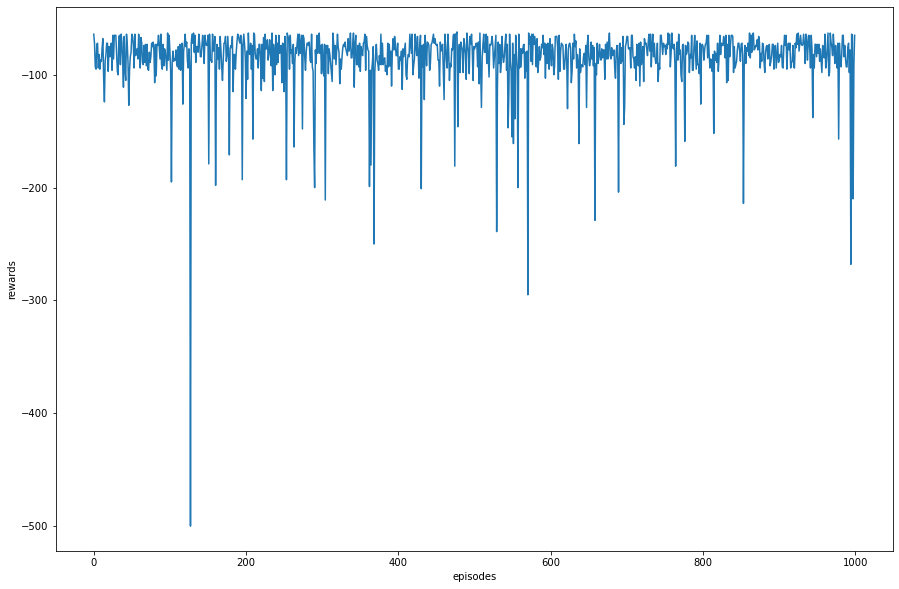

In [102]:
fig, axes = plt.subplots(figsize=(15,10))
plot(np.arange(len(r)), r)
plt.xlabel('episodes')
plt.ylabel('rewards')
show()

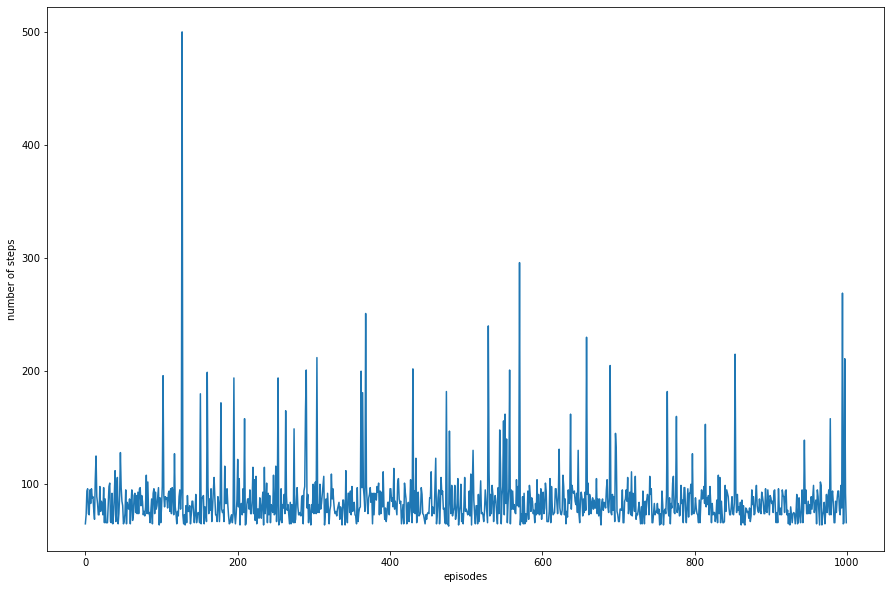

In [103]:
fig, axes = plt.subplots(figsize=(15,10))
plot(np.arange(len(ns)), ns)
plt.xlabel('episodes')
plt.ylabel('number of steps')
show()

In order to evaluate the performance we will also add the sum of the number of wins after each episode, by the description of how th environment works, it is noted that if the chain reached the given hight with a reward more than -100 then it is considered a win otherwise it is a loss, so we will count the number of times the reward is more than -100 in the next code chunk

total number of wins:  899


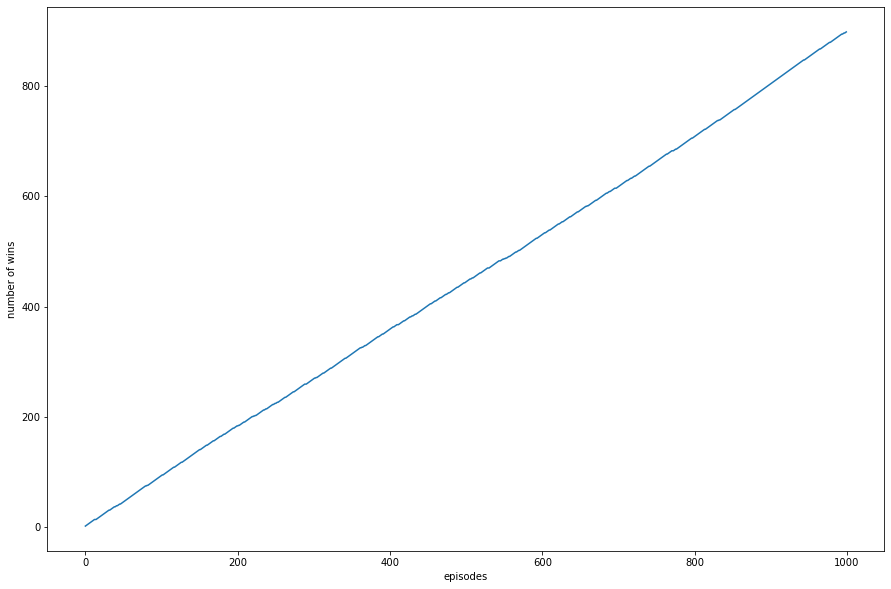

In [104]:
wins = [1*(i>-100) for i in r]
wins = np.cumsum(wins)
print('total number of wins: ',wins[-1])
fig, axes = plt.subplots(figsize=(15,10))
plot(np.arange(len(wins)), wins)
plt.xlabel('episodes')
plt.ylabel('number of wins')
show()

## Adding observations

In the observation variables we have access to the cos and sin of the angles of each link forming the chain respectively to a base, but in fact the position of the chain is better determined if we knew the value of the cos and sin of the difference of these two angles, so in the next code we're going to add two more observations that are $cos(\theta_2-\theta_1)$ and $sin(\theta_2-\theta_1)$ and see if this change will improve the performance of our algorithm or will not make a big difference

In [90]:
def add_obs(x):
    cos1 = x[0]
    sin1 = x[1]
    cos2 = x[2]
    sin2 = x[3]
    cosdiff = cos1*cos2 + sin1*sin2
    sindiff = sin1*cos2 - sin2*cos1
    
    return np.append(x,[cosdiff, sindiff])

In [91]:
def reinforce2(env, learning_rate, gamma, max_episodes, max_steps=500):
    # Get state and action space dimensions
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    # Initialize policy parameters
    theta = np.random.rand(action_dim,state_dim+2)
    for episode in tqdm(range(max_episodes)):
        # Initialize lists for states, actions, and rewards for the current episode
        rewards = []
        grads = []
        # Reset environment to start new episode
        state = env.reset()
        state= add_obs(state[0])
        # Generate a complete episode following the current policy
        done = False
        for step in range(max_steps):
            # Get action probabilities from current policy
            action_probs = policy_func(state, theta)
            # Sample action from action probabilities
            action = np.random.choice(action_dim, p=action_probs)
            # Take action and observe next state and reward
            next_state, reward, done, _,_ = env.step(action)
            # Append state, action, and reward to episode lists
            rewards.append(reward)
            grad = grad_log_policy(state, action, action_probs)
            grads.append(grad)
            # Update state for next iteration
            state = add_obs(next_state)
            if done :
                break
            
        # Compute rewards-to-go for each state in the episode
        for t in range(len(rewards)):
            reward_to_go = sum([gamma**(k-t-1) * rewards[k] for k in range(t+1, len(rewards))])
        # Update policy parameters using rewards-to-go and current episode states/actions
            theta += learning_rate*grads[t]*reward_to_go
    return theta


In [92]:
env = gym.make('Acrobot-v1', render_mode=None)
theta2 = reinforce2(env,0.0001,0.99,5000)

  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]C:\Users\ADR001\anaconda3\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:56<00:00, 88.12it/s]


In [105]:
def play_game2(env, theta, max_episodes, max_steps=500):
    trewards = []
    num_steps = []
    for episode in tqdm(range(max_episodes)):
        state = env.reset()
        state= add_obs(state[0])
        total_reward = 0
        for step in range(max_steps):
            action_probs = policy_func(state, theta)
            action = np.random.choice(3, p=action_probs)
            next_state, reward, done,_,_ = env.step(action)
            total_reward+=reward
            state = add_obs(next_state)
            if done :
                break
        trewards.append(total_reward)
        num_steps.append(step+1)

    return trewards, num_steps

In [109]:
env = gym.make('Acrobot-v1', render_mode=None)
r2,ns2 = play_game2(env,theta2,1000)
print('le nombre moyen des étapes: ',np.mean(ns2))
print('la moyenne des récompenses', np.mean(r2))

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.70it/s]

le nombre moyen des étapes:  86.936
la moyenne des récompenses -85.938


__rewards by episodes with added observations__

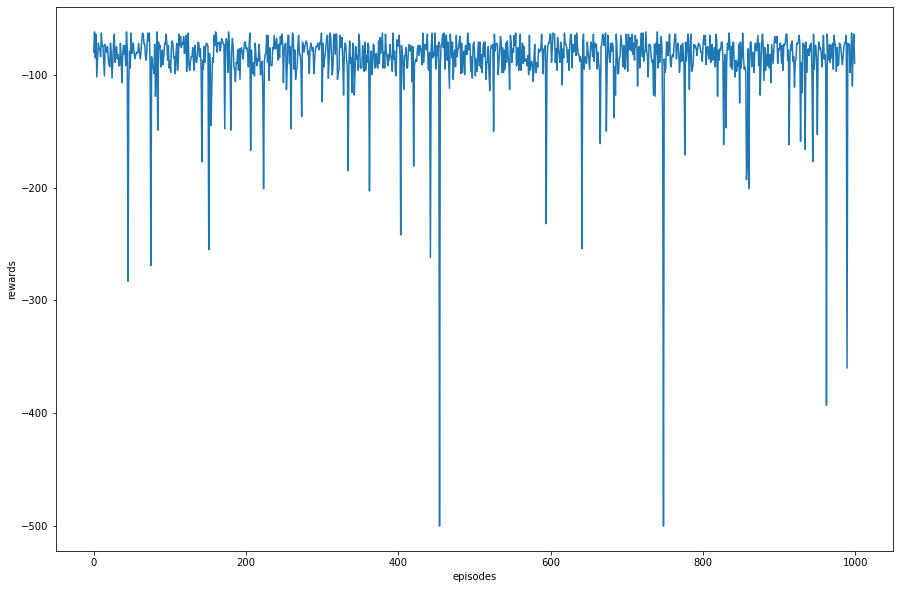

In [110]:
fig, axes = plt.subplots(figsize=(15,10))
plot(np.arange(len(r2)), r2)
plt.xlabel('episodes')
plt.ylabel('rewards')
show()

__number of steps by episodes with added observations__

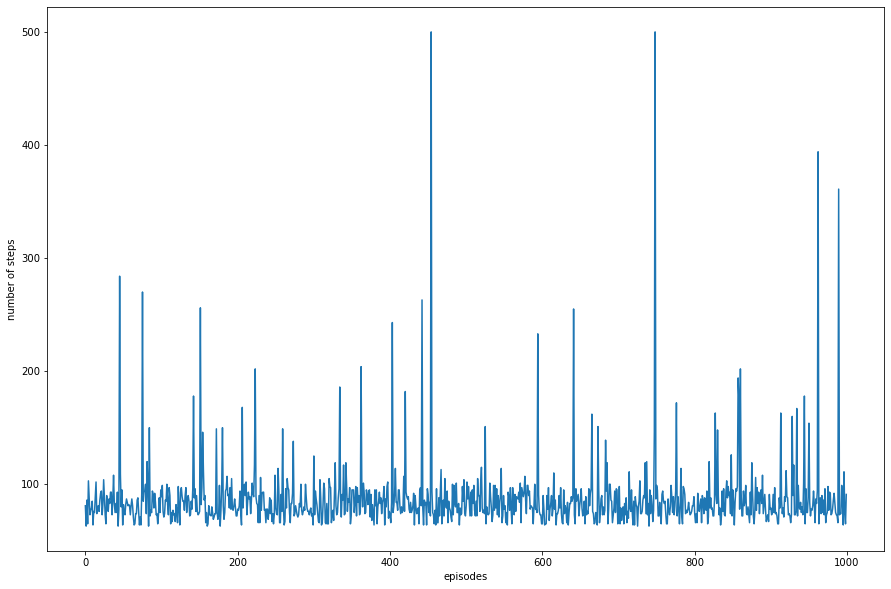

In [111]:
fig, axes = plt.subplots(figsize=(15,10))
plot(np.arange(len(ns2)), ns2)
plt.xlabel('episodes')
plt.ylabel('number of steps')
show()

__number of wins by episodes with added observations__

total number of wins:  904


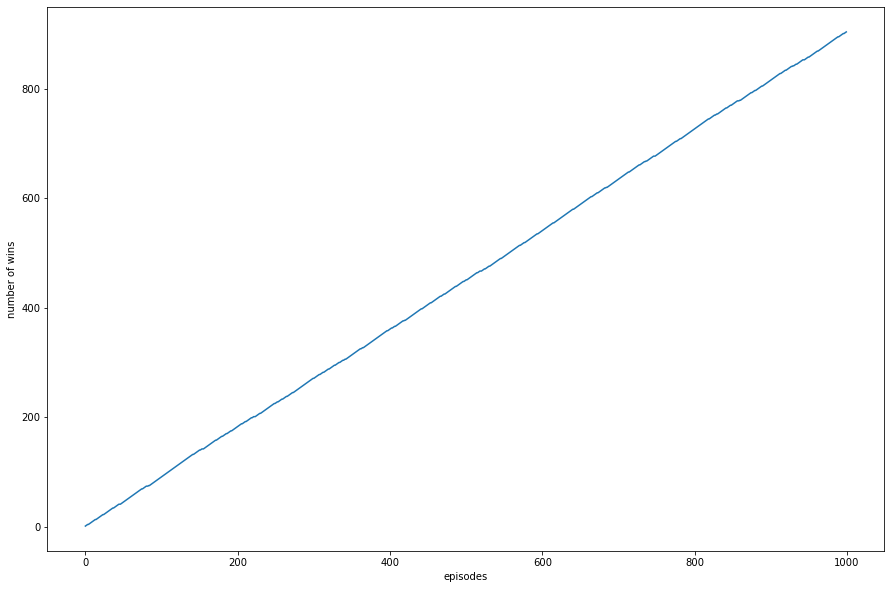

In [112]:
wins2 = [1*(i>-100) for i in r2]
wins2 = np.cumsum(wins2)
print('total number of wins: ',wins2[-1])
fig, axes = plt.subplots(figsize=(15,10))
plot(np.arange(len(wins2)), wins2)
plt.xlabel('episodes')
plt.ylabel('number of wins')
show()

We can see that adding these observations didn't change much in the algorithm's performance

## parameters tuning

In this part we will be using the same principle of Gridsearch and trying to find the couple of the discount factor and the learning rate that will maximise the number of wins, the following code does so:

In [118]:
import itertools

# Define hyperparameters to test
gammas = [0.8,0.85,0.9,0.95,0.99]
learning_rates = [0.00001,0.00005,0.0001,0.0005]

# Create list of hyperparameter combinations
param_combinations = list(itertools.product(gammas, learning_rates))

# Initialize results list
results = []

# Run reinforcement learning with each hyperparameter combination
for gamma, learning_rate in param_combinations:
    env = gym.make('Acrobot-v1')
    theta_test = reinforce(env, learning_rate=learning_rate, gamma=gamma, max_episodes=1000)
    total_reward,_ = play_game(env, theta_test,500)
    wins = [1*(i>-100) for i in total_reward]
    wins = np.sum(wins)
    results.append((gamma, learning_rate, wins))

# Print results
best = -inf
for gamma, learning_rate, wins in results:
    if wins > best:
        best = wins
        best_gamma = gamma
        best_lr = learning_rate
print(f"Gamma: {best_gamma}, Learning Rate: {best_lr}, number of wins: {best}")


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:34<00:00, 14.66it/s]

Gamma: 0.99, Learning Rate: 0.0001, number of wins: 405


We found that for $\gamma = 0.99$ and $\eta = 0.0001$ gives us the best results which means that the values that we got earlier in this document are the best values we can get respectively to the hyperparameters

## Conclusion

Our experimental results showed that the Reinforce algorithm can effectively learn a policy that solves the Acrobot problem, achieving an average episode reward of over -100.

Furthermore, we found that tuning the hyperparameters of the algorithm improved its performance, with the best values for the learning rate and discount factor being 0.0001 and 0.99, respectively.

Nevertheless, adding observations didn't make a difference in the performance.

Overall, our project demonstrated the effectiveness of the algorithm and the policy we provided to solve the Acrobot problem.